# Explore trained models

In [1]:
from src.data.pipelines import convnet_pipeline
from src.models import early_convnet

import os
import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-19 23:04:09.059250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# Pipeline
BATCH_SIZE_IMAGES = 1
BATCH_SIZE_PATCHES = 1
IMAGE_SIZE = 224
PATCH_SIZE = 40
PATCH_SIZE_ANNOTATION = 2
PATCH_STRIDE = 1
SLICE_TRAIN = ':10'
SLICE_VALID = '10:12'
SLICE_TEST = '720:800'

checkpoint_filepath = os.path.join(os.getcwd(),'..', 'models', 'ckpt', 'early_convnet')

In [21]:
input_pipeline = convnet_pipeline.ConvnetPipeline(
    SLICE_TRAIN,
    SLICE_VALID,
    SLICE_TEST,
    BATCH_SIZE_IMAGES,
    BATCH_SIZE_PATCHES,
    IMAGE_SIZE,
    PATCH_SIZE,
    PATCH_SIZE_ANNOTATION,
    PATCH_STRIDE
)

In [13]:
def index_to_rgb(indexed_image):
    palette = [
        [0, 255, 255],   # urban_land
        [255, 255, 0],   # agriculture_land
        [255, 0, 255],   # rangeland
        [0, 255, 0],     # forest_land
        [0, 0, 255],     # water
        [255, 255, 255], # barren_land
        [0, 0, 0]        # unknown
    ]

    # Convert indexed image to one-hot representation
    one_hot_map = tf.one_hot(tf.squeeze(indexed_image, axis=-1), depth=len(palette), dtype=tf.float32)

    # Use one-hot map and palette to reconstruct RGB image
    reconstructed_image = tf.reduce_sum(tf.expand_dims(one_hot_map, axis=-1) * tf.constant(palette, dtype=tf.float32), axis=-2)

    return tf.cast(reconstructed_image, dtype=tf.uint8)

In [17]:
def display(display_list, file_name):
    plt.figure(figsize=(5, 5))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        data = display_list[i][0]
        if i > 0:
            data = index_to_rgb(data)
        plt.imshow(tf.keras.utils.array_to_img(data, data_format='channels_last'))
        plt.axis('off')
    plt.suptitle(file_name[0].numpy())
    plt.show()

In [10]:
checkpoint_filepath

'/workspaces/CM3070_Final_project/notebooks/../models/ckpt/early_convnet'

In [11]:
model = early_convnet.EarlyConvnet()
latest = tf.train.latest_checkpoint(checkpoint_filepath)
model.build((None, PATCH_SIZE, PATCH_SIZE, 3))
model.load_weights(latest)

(34225, 40, 40, 3)
1070/1070 [==============================] - 6s 6ms/step
3


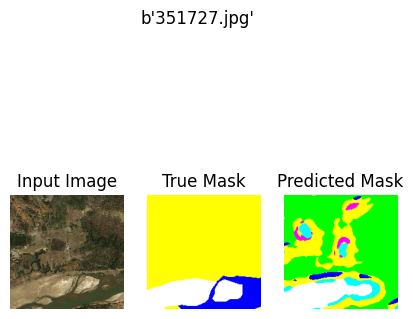

(34225, 40, 40, 3)
1070/1070 [==============================] - 4s 4ms/step
3


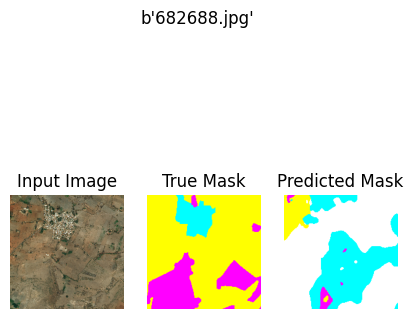

(34225, 40, 40, 3)
1070/1070 [==============================] - 4s 4ms/step
3


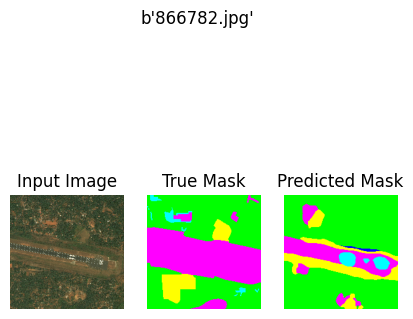

(34225, 40, 40, 3)
1070/1070 [==============================] - 4s 3ms/step
3


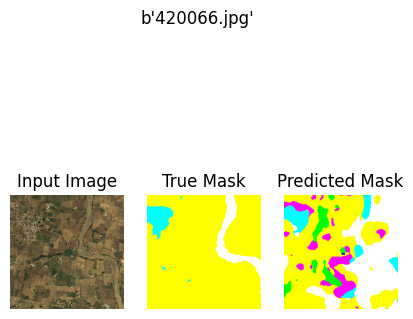

In [19]:
for p, m, i, file_name in input_pipeline.test.skip(16).take(4):
    # print(tf.unique(tf.argmax(tf.reshape(m, shape=[-1, 7]), axis=1)))
    gt = m
    print(p.shape)
    y = model.predict(p)
    gt_mask = tf.reshape(tf.argmax(input=gt, axis=3), shape=(1, 185, 185, 1))
    mask = tf.reshape(tf.argmax(input=y, axis=3), shape=(1, 185, 185, 1))
    display([i, gt_mask, mask], file_name)
    # display(gt_mask)